## **OFA**
Start to enjoy visual grounding with OFA! 

## **Download Checkpoint**
We provide a link for our public checkpoint, and you only need to wget it to your workspace. We also provide an alternative below. Choose one as you like!

## **Install Fairseq**
We advise you to install fairseq by cloning the official repository and running "pip install". 

You should restart the window if you meet the hint of "RESTART RUNTIME". 

## **Preparation**
Below you just need to import required packages, and check whether to use GPU or FP16. 

In [73]:
import torch
import numpy as np
from fairseq import utils, tasks
from fairseq import checkpoint_utils
from utils.eval_utils import eval_step
from tasks.mm_tasks.refcoco import RefcocoTask
from models.ofa import OFAModel
from PIL import Image
import os

os.environ["CUDA_VISIBLE_DEVICES"]="2,3,4,5"

# Register refcoco task
tasks.register_task('refcoco', RefcocoTask)

# turn on cuda if GPU is available
use_cuda = torch.cuda.is_available()
# use fp16 only when GPU is available
use_fp16 = False

## **Build Model**
Below you can build your model and load the weights from the given checkpoint, and also build a generator. 

In [74]:
# Load pretrained ckpt & config
overrides={"bpe_dir":"utils/BPE"}
# model_path = '/data/jhkim/iros23/OFA_checkpoints/refcoco_large_best.pt'
# model_path = '/data/jhkim/iros23/OFA_refcoco_checkpoints_0208_pick/0208_train_135/checkpoint_last.pt' #random
# model_path = '/data/jhkim/icra24/ofa_checkpoints/passive/checkpoint_best.pt'
# model_path = '/data/jhkim/icra24/ofa_checkpoints/propagation_ignore/checkpoint_best.pt'
# model_path = '/data/jhkim/icra24/ofa_checkpoints/propagation_ignore_from2/checkpoint_best.pt'
model_path = '/data/jhkim/icra24/ofa_checkpoints/gt_ignore_from2/checkpoint_best.pt'

# 100, 200, 300
# model_path = '/data/jhkim/icra24/ofa_checkpoints/propagation_ignore_from2_100_seed_666/checkpoint_best.pt'
# model_path = '/data/jhkim/icra24/ofa_checkpoints/propagation_ignore_from2_100_seed_777/checkpoint_best.pt'
# model_path = '/data/jhkim/icra24/ofa_checkpoints/propagation_ignore_from2_100_seed_888/checkpoint_best.pt'
# model_path = '/data/jhkim/icra24/ofa_checkpoints/propagation_ignore_from2_25_seed_666/checkpoint_best.pt'
# model_path = '/data/jhkim/icra24/ofa_checkpoints/propagation_ignore_from2_25_seed_777/checkpoint_best.pt'
# model_path = '/data/jhkim/icra24/ofa_checkpoints/propagation_ignore_from2_25_seed_888/checkpoint_best.pt'


# model_path = '/data/jhkim/icra24/ofa_checkpoints/gpt_ignore_from2/checkpoint_best.pt'

models, cfg, task = checkpoint_utils.load_model_ensemble_and_task(
        utils.split_paths(model_path),
        arg_overrides=overrides
    )

cfg.common.seed = 7
cfg.generation.beam = 5
cfg.generation.min_len = 4
cfg.generation.max_len_a = 0
cfg.generation.max_len_b = 4
cfg.generation.no_repeat_ngram_size = 3

# Fix seed for stochastic decoding
if cfg.common.seed is not None and not cfg.generation.no_seed_provided:
    np.random.seed(cfg.common.seed)
    utils.set_torch_seed(cfg.common.seed)

# Move models to GPU
for model in models:
    model.eval()
    if use_fp16:
        model.half()
    if use_cuda and not cfg.distributed_training.pipeline_model_parallel:
        model.cuda()
    model.prepare_for_inference_(cfg)

# Initialize generator
generator = task.build_generator(models, cfg.generation)

2023-08-16 19:36:26 | INFO | tasks.ofa_task | source dictionary: 59457 types
2023-08-16 19:36:26 | INFO | tasks.ofa_task | target dictionary: 59457 types


## **Preprocess**
We demonstrate the required transformation fucntions for preprocessing inputs.

In [75]:
# Image transform
from torchvision import transforms
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((cfg.task.patch_image_size, cfg.task.patch_image_size), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Text preprocess
bos_item = torch.LongTensor([task.src_dict.bos()])
eos_item = torch.LongTensor([task.src_dict.eos()])
pad_idx = task.src_dict.pad()
def encode_text(text, length=None, append_bos=False, append_eos=False):
    s = task.tgt_dict.encode_line(
        line=task.bpe.encode(text.lower()),
        add_if_not_exist=False,
        append_eos=False
    ).long()
    if length is not None:
        s = s[:length]
    if append_bos:
        s = torch.cat([bos_item, s])
    if append_eos:
        s = torch.cat([s, eos_item])
    return s

# Construct input for refcoco task
patch_image_size = cfg.task.patch_image_size
def construct_sample(image: Image, text: str):
    w, h = image.size
    w_resize_ratio = torch.tensor(patch_image_size / w).unsqueeze(0)
    h_resize_ratio = torch.tensor(patch_image_size / h).unsqueeze(0)
    patch_image = patch_resize_transform(image).unsqueeze(0)
    patch_mask = torch.tensor([True])
    src_text = encode_text(' which region does the text " {} " describe?'.format(text), append_bos=True, append_eos=True).unsqueeze(0)
    src_length = torch.LongTensor([s.ne(pad_idx).long().sum() for s in src_text])
    sample = {
        "id":np.array(['42']),
        "net_input": {
            "src_tokens": src_text,
            "src_lengths": src_length,
            "patch_images": patch_image,
            "patch_masks": patch_mask,
        },
        "w_resize_ratios": w_resize_ratio,
        "h_resize_ratios": h_resize_ratio,
        "region_coords": torch.randn(1, 4)
    }
    return sample
  
# Function to turn FP32 to FP16
def apply_half(t):
    if t.dtype is torch.float32:
        return t.to(dtype=torch.half)
    return t

/home/jhkim/anaconda3/envs/ofa/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  


## **Run Inference**
Download an image and run the following scripts to generate the result.

In [76]:
import torch
test_path = '/data/jhkim/icra24/ofa_vg_data/test_annotation/seen_random.pth'
answer = torch.load(test_path)

In [77]:
# image = Image.open('/data/jhkim/icra24/raw_images/test/seen_random/0.png')
# image = image.crop((0,150,image.size[0],image.size[1]))
# text = "object" 
q = 4
image = Image.open('/data/jhkim/icra24/raw_images/test/seen_random/{}'.format(answer[q][0]))
text = answer[q][2]
gt_box = answer[q][3]
# Construct input sample & preprocess for GPU if cuda available
sample = construct_sample(image, text)
sample = utils.move_to_cuda(sample) if use_cuda else sample

# Run eval step for refcoco
with torch.no_grad():
    result, scores = eval_step(task, generator, models, sample)

1.png
my plushie, Ruby


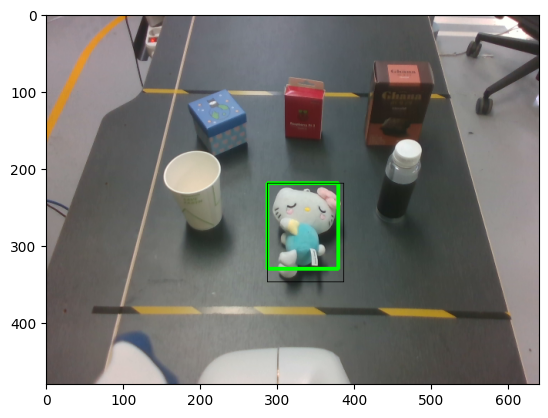

In [78]:
import cv2
import numpy

img = cv2.cvtColor(numpy.asarray(image), cv2.COLOR_RGB2BGR)
cv2.rectangle(
    img,
    (int(result[0]["box"][0]), int(result[0]["box"][1])),
    (int(result[0]["box"][2]), int(result[0]["box"][3])),
    (0, 255, 0),
    3
)

cv2.rectangle(
    img,
    (int(gt_box[0]), int(gt_box[1])),
    (int(gt_box[2]), int(gt_box[3])),
    (0, 0, 0),
    1
)
#print(result[0]["box"])

from matplotlib import pyplot as plt
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
print(answer[q][0])
print(text)

# Evaluation Code

In [79]:
def IoU(box1, box2):
    # box = (x1, y1, x2, y2)
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # obtain x1, y1, x2, y2 of the intersection
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # compute the width and height of the intersection
    w = max(0, x2 - x1 + 1)
    h = max(0, y2 - y1 + 1)

    inter = w * h
    iou = inter / (box1_area + box2_area - inter)
    return iou

### validation (= test1)

In [81]:
import random
random.seed(2023)

testsplits = ['seen_random', 'seen_same', 'unseen_random', 'unseen_same', 'cluttered']

for split in testsplits:
    #for original split
    test_path = '/data/jhkim/icra24/ofa_vg_data/test_annotation/{}.pth'.format(split)
    answer = torch.load(test_path)

    yes_cnt_5 = 0
    yes_cnt_8 = 0

    # answer = random.sample(answer,15)
    for i, anw in enumerate(answer):
        image = Image.open('/data/jhkim/icra24/raw_images/test/{}/{}'.format(split,anw[0]))
        text = anw[2] 

        # Construct input sample & preprocess for GPU if cuda available
        sample = construct_sample(image, text)
        sample = utils.move_to_cuda(sample) if use_cuda else sample
        sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample
        with torch.no_grad():
            result, scores = eval_step(task, generator, models, sample)
        try:
            if IoU(result[0]['box'], anw[3]) > 0.5:
                yes_cnt_5 += 1
            if IoU(result[0]['box'], anw[3]) > 0.8:
                yes_cnt_8 += 1
        except:
            print("what")
    print("{}: {:.1f}".format(split,100*yes_cnt_5/(i)))
    # print("{} (IoU 0.8): {:.1f}".format(split,100*yes_cnt_8/i))

    # # for paraphrased split
    # test_path = '/data/jhkim/icra24/ofa_vg_data/test_annotation/para_{}.pth'.format(split)
    # answer = torch.load(test_path)

    # yes_cnt_5 = 0
    # yes_cnt_8 = 0
    # for i, anw in enumerate(answer):
    #     image = Image.open('/data/jhkim/icra24/raw_images/test/{}/{}'.format(split,anw[0]))
    #     text = anw[2] 

    #     # Construct input sample & preprocess for GPU if cuda available
    #     sample = construct_sample(image, text)
    #     sample = utils.move_to_cuda(sample) if use_cuda else sample
    #     sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample
    #     with torch.no_grad():
    #         result, scores = eval_step(task, generator, models, sample)
    #     try:
    #         if IoU(result[0]['box'], anw[3]) > 0.5:
    #             yes_cnt_5 += 1
    #         if IoU(result[0]['box'], anw[3]) > 0.8:
    #             yes_cnt_8 += 1
    #         # else:
    #         #     print(i)
    #     except:
    #         print("what")
    # print("para_{}: {:.1f}".format(split,100*yes_cnt_5/i))
    # print("para_{} (IoU 0.8): {:.1f}".format(split,100*yes_cnt_8/i))



seen_random: 93.3
seen_same: 93.3
unseen_random: 100.0
unseen_same: 80.0
cluttered: 93.3


# Model Scores

## For Reminiscnece 25,100

## Seed = 777
### 25

seen_random: 52.5
seen_random (IoU 0.8): 47.5
para_seen_random: 54.2
para_seen_random (IoU 0.8): 49.2

seen_same: 55.9
seen_same (IoU 0.8): 50.8
para_seen_same: 52.5
para_seen_same (IoU 0.8): 49.2

unseen_random: 69.5
unseen_random (IoU 0.8): 57.6
para_unseen_random: 62.7
para_unseen_random (IoU 0.8): 52.5

unseen_same: 35.6
unseen_same (IoU 0.8): 32.2
para_unseen_same: 33.9
para_unseen_same (IoU 0.8): 28.8

cluttered: 59.3
cluttered (IoU 0.8): 49.7
para_cluttered: 59.6
para_cluttered (IoU 0.8): 48.8

## Seed = 888
### 25

seen_random: 54.2
seen_random (IoU 0.8): 52.5
para_seen_random: 55.9
para_seen_random (IoU 0.8): 52.5

seen_same: 50.8
seen_same (IoU 0.8): 40.7
para_seen_same: 50.8
para_seen_same (IoU 0.8): 42.4

unseen_random: 74.6
unseen_random (IoU 0.8): 64.4
para_unseen_random: 66.1
para_unseen_random (IoU 0.8): 57.6

unseen_same: 42.4
unseen_same (IoU 0.8): 39.0
para_unseen_same: 35.6
para_unseen_same (IoU 0.8): 30.5

cluttered: 65.7
cluttered (IoU 0.8): 56.0
para_cluttered: 63.6
para_cluttered (IoU 0.8): 53.9

## Seed = 666
### 25

seen_random: 69.5
seen_random (IoU 0.8): 66.1
para_seen_random: 71.2
para_seen_random (IoU 0.8): 67.8

seen_same: 50.8
seen_same (IoU 0.8): 42.4
para_seen_same: 52.5
para_seen_same (IoU 0.8): 45.8

unseen_random: 67.8
unseen_random (IoU 0.8): 57.6
para_unseen_random: 66.1
para_unseen_random (IoU 0.8): 55.9

unseen_same: 40.7
unseen_same (IoU 0.8): 35.6
para_unseen_same: 32.2
para_unseen_same (IoU 0.8): 27.1

cluttered: 62.3
cluttered (IoU 0.8): 53.0
para_cluttered: 63.6
para_cluttered (IoU 0.8): 53.3

## Seed = 777
### 100

seen_random: 74.6
seen_random (IoU 0.8): 67.8
para_seen_random: 67.8
para_seen_random (IoU 0.8): 64.4

seen_same: 59.3
seen_same (IoU 0.8): 49.2
para_seen_same: 62.7
para_seen_same (IoU 0.8): 55.9

unseen_random: 72.9
unseen_random (IoU 0.8): 61.0
para_unseen_random: 74.6
para_unseen_random (IoU 0.8): 64.4

unseen_same: 45.8
unseen_same (IoU 0.8): 45.8
para_unseen_same: 45.8
para_unseen_same (IoU 0.8): 40.7

cluttered: 75.6
cluttered (IoU 0.8): 63.3
para_cluttered: 69.0
para_cluttered (IoU 0.8): 56.3

## Seed = 888
### 100

seen_random: 79.7
seen_random (IoU 0.8): 78.0
para_seen_random: 76.3
para_seen_random (IoU 0.8): 74.6

seen_same: 64.4
seen_same (IoU 0.8): 57.6
para_seen_same: 66.1
para_seen_same (IoU 0.8): 62.7

unseen_random: 76.3
unseen_random (IoU 0.8): 62.7
para_unseen_random: 78.0
para_unseen_random (IoU 0.8): 61.0

unseen_same: 54.2
unseen_same (IoU 0.8): 52.5
para_unseen_same: 50.8
para_unseen_same (IoU 0.8): 49.2

cluttered: 76.8
cluttered (IoU 0.8): 63.0
para_cluttered: 69.9
para_cluttered (IoU 0.8): 56.0

## Seed = 666
### 100

seen_random: 78.0
seen_random (IoU 0.8): 71.2
para_seen_random: 78.0
para_seen_random (IoU 0.8): 71.2

seen_same: 64.4
seen_same (IoU 0.8): 54.2
para_seen_same: 69.5
para_seen_same (IoU 0.8): 61.0

unseen_random: 81.4
unseen_random (IoU 0.8): 71.2
para_unseen_random: 79.7
para_unseen_random (IoU 0.8): 69.5

unseen_same: 49.2
unseen_same (IoU 0.8): 40.7
para_unseen_same: 42.4
para_unseen_same (IoU 0.8): 37.3

cluttered: 75.9
cluttered (IoU 0.8): 63.0
para_cluttered: 69.6
para_cluttered (IoU 0.8): 56.6

# Real!!!

## OFA

seen_random: 44.1
seen_random (IoU 0.8): 40.7
para_seen_random: 40.7
para_seen_random (IoU 0.8): 39.0

seen_same: 28.8
seen_same (IoU 0.8): 22.0
para_seen_same: 27.1
para_seen_same (IoU 0.8): 20.3

unseen_random: 54.2
unseen_random (IoU 0.8): 54.2
para_unseen_random: 54.2
para_unseen_random (IoU 0.8): 54.2

unseen_same: 18.6
unseen_same (IoU 0.8): 18.6
para_unseen_same: 18.6
para_unseen_same (IoU 0.8): 18.6

cluttered: 41.9
cluttered (IoU 0.8): 34.6
para_cluttered: 45.5
para_cluttered (IoU 0.8): 38.6

## GVCCI

seen_random: 59.3
seen_random (IoU 0.8): 54.2
para_seen_random: 49.2
para_seen_random (IoU 0.8): 45.8

seen_same: 40.7
seen_same (IoU 0.8): 32.2
para_seen_same: 40.7
para_seen_same (IoU 0.8): 35.6

unseen_random: 59.3
unseen_random (IoU 0.8): 55.9
para_unseen_random: 57.6
para_unseen_random (IoU 0.8): 54.2

unseen_same: 20.3
unseen_same (IoU 0.8): 15.3
para_unseen_same: 18.6
para_unseen_same (IoU 0.8): 13.6

cluttered: 58.7
cluttered (IoU 0.8): 44.3
para_cluttered: 60.8
para_cluttered (IoU 0.8): 45.2

## Passive

seen_random: 50.8
seen_random (IoU 0.8): 45.8
para_seen_random: 52.5
para_seen_random (IoU 0.8): 50.8

seen_same: 44.1
seen_same (IoU 0.8): 28.8
para_seen_same: 45.8
para_seen_same (IoU 0.8): 28.8

unseen_random: 69.5
unseen_random (IoU 0.8): 64.4
para_unseen_random: 64.4
para_unseen_random (IoU 0.8): 59.3

unseen_same: 30.5
unseen_same (IoU 0.8): 25.4
para_unseen_same: 33.9
para_unseen_same (IoU 0.8): 28.8

cluttered: 59.0
cluttered (IoU 0.8): 46.4
para_cluttered: 58.4
para_cluttered (IoU 0.8): 44.9

## Propagation ignore

seen_random: 91.5
seen_random (IoU 0.8): 81.4
para_seen_random: 89.8
para_seen_random (IoU 0.8): 79.7

seen_same: 71.2
seen_same (IoU 0.8): 59.3
para_seen_same: 69.5
para_seen_same (IoU 0.8): 59.3

unseen_random: 86.4
unseen_random (IoU 0.8): 71.2
para_unseen_random: 83.1
para_unseen_random (IoU 0.8): 67.8

unseen_same: 66.1
unseen_same (IoU 0.8): 47.5
para_unseen_same: 64.4
para_unseen_same (IoU 0.8): 45.8

cluttered: 79.8
cluttered (IoU 0.8): 62.3
para_cluttered: 78.3
para_cluttered (IoU 0.8): 61.1

## Propagation

seen_random: 91.5
seen_random (IoU 0.8): 84.7
para_seen_random: 89.8
para_seen_random (IoU 0.8): 83.1

seen_same: 72.9
seen_same (IoU 0.8): 66.1
para_seen_same: 74.6
para_seen_same (IoU 0.8): 67.8

unseen_random: 91.5
unseen_random (IoU 0.8): 78.0
para_unseen_random: 83.1
para_unseen_random (IoU 0.8): 71.2

unseen_same: 67.8
unseen_same (IoU 0.8): 57.6
para_unseen_same: 64.4
para_unseen_same (IoU 0.8): 57.6

cluttered: 78.6
cluttered (IoU 0.8): 64.5
para_cluttered: 76.5
para_cluttered (IoU 0.8): 61.4

## GT

seen_random: 100.0
seen_random (IoU 0.8): 94.9
para_seen_random: 96.6
para_seen_random (IoU 0.8): 91.5

seen_same: 96.6
seen_same (IoU 0.8): 86.4
para_seen_same: 91.5
para_seen_same (IoU 0.8): 81.4

unseen_random: 94.9
unseen_random (IoU 0.8): 86.4
para_unseen_random: 93.2
para_unseen_random (IoU 0.8): 88.1

unseen_same: 88.1
unseen_same (IoU 0.8): 79.7
para_unseen_same: 78.0
para_unseen_same (IoU 0.8): 69.5

cluttered: 88.0
cluttered (IoU 0.8): 71.4
para_cluttered: 83.4
para_cluttered (IoU 0.8): 64.5

## with 96 objects

### passive

### propagation (without interaction)

### propagation

seen_random: 0.7458
seen_random (IoU 0.8): 0.6441
para_seen_random: 0.6949
seen_random (IoU 0.8): 0.6102

seen_same: 0.6780
seen_same (IoU 0.8): 0.5593
para_seen_same: 0.6949
seen_same (IoU 0.8): 0.6271

unseen_random: 0.7458
unseen_random (IoU 0.8): 0.6102
para_unseen_random: 0.7119
unseen_random (IoU 0.8): 0.5932

unseen_same: 0.6102
unseen_same (IoU 0.8): 0.4746
para_unseen_same: 0.5763
unseen_same (IoU 0.8): 0.4407

cluttered: 0.8072
cluttered (IoU 0.8): 0.6627
para_cluttered: 0.7831
cluttered (IoU 0.8): 0.6476

### propagation ignore (with label propagation without interaction)

seen_random: 0.8814
seen_random (IoU 0.8): 0.7288
para_seen_random: 0.8644
seen_random (IoU 0.8): 0.7288

seen_same: 0.7119
seen_same (IoU 0.8): 0.5932
para_seen_same: 0.6949
seen_same (IoU 0.8): 0.5932

unseen_random: 0.8644
unseen_random (IoU 0.8): 0.7119
para_unseen_random: 0.8305
unseen_random (IoU 0.8): 0.6780

unseen_same: 0.6610
unseen_same (IoU 0.8): 0.4746
para_unseen_same: 0.6441
unseen_same (IoU 0.8): 0.4576

cluttered: 0.7982
cluttered (IoU 0.8): 0.6235
para_cluttered: 0.7831
cluttered (IoU 0.8): 0.6114

### propagation ignore from 2

seen_random: 0.8136
seen_random (IoU 0.8): 0.6949
para_seen_random: 0.7627
seen_random (IoU 0.8): 0.6610

seen_same: 0.7288
seen_same (IoU 0.8): 0.6610
para_seen_same: 0.7458
seen_same (IoU 0.8): 0.6780

unseen_random: 0.9153
unseen_random (IoU 0.8): 0.7797
para_unseen_random: 0.8305
unseen_random (IoU 0.8): 0.7119

unseen_same: 0.6780
unseen_same (IoU 0.8): 0.5763
para_unseen_same: 0.6441
unseen_same (IoU 0.8): 0.5763

cluttered: 0.7861
cluttered (IoU 0.8): 0.6446
para_cluttered: 0.7651
cluttered (IoU 0.8): 0.6145

### GPT

### GPT ignore
seen_random: 0.8814
seen_random (IoU 0.8): 0.7458
para_seen_random: 0.8475
seen_random (IoU 0.8): 0.7288

seen_same: 0.6780
seen_same (IoU 0.8): 0.5254
para_seen_same: 0.6949
seen_same (IoU 0.8): 0.5593

unseen_random: 0.8814
unseen_random (IoU 0.8): 0.7119
para_unseen_random: 0.8305
unseen_random (IoU 0.8): 0.6780

unseen_same: 0.5763
unseen_same (IoU 0.8): 0.3898
para_unseen_same: 0.6271
unseen_same (IoU 0.8): 0.4068

cluttered: 0.7590
cluttered (IoU 0.8): 0.5392
para_cluttered: 0.7801
cluttered (IoU 0.8): 0.5663

### GPT ignore from 2

seen_random: 0.8136
seen_random (IoU 0.8): 0.6610
para_seen_random: 0.7966
seen_random (IoU 0.8): 0.6780

seen_same: 0.7458
seen_same (IoU 0.8): 0.6610
para_seen_same: 0.7288
seen_same (IoU 0.8): 0.6780

unseen_random: 0.8136
unseen_random (IoU 0.8): 0.6610
para_unseen_random: 0.8136
unseen_random (IoU 0.8): 0.6780

unseen_same: 0.6102
unseen_same (IoU 0.8): 0.4746
para_unseen_same: 0.6271
unseen_same (IoU 0.8): 0.4915

cluttered: 0.7440
cluttered (IoU 0.8): 0.5783
para_cluttered: 0.7380
cluttered (IoU 0.8): 0.5663

### GT

## with 83 objects

### OFA

seen_random: 0.4068
seen_random (IoU 0.8): 0.3729
para_seen_random: 0.3898
seen_random (IoU 0.8): 0.3390

seen_same: 0.2881
seen_same (IoU 0.8): 0.2203
para_seen_same: 0.2712
seen_same (IoU 0.8): 0.2034

unseen_random: 0.5424
unseen_random (IoU 0.8): 0.5424
para_unseen_random: 0.5424
unseen_random (IoU 0.8): 0.5424

unseen_same: 0.1864
unseen_same (IoU 0.8): 0.1864
para_unseen_same: 0.1864
unseen_same (IoU 0.8): 0.1864

cluttered: 0.4187
cluttered (IoU 0.8): 0.3464
para_cluttered: 0.4548
cluttered (IoU 0.8): 0.3855

### Generic(GVCCI)

seen_random: 0.5763
seen_random (IoU 0.8): 0.4915
para_seen_random: 0.5085
seen_random (IoU 0.8): 0.4237

seen_same: 0.4068
seen_same (IoU 0.8): 0.3220
para_seen_same: 0.4068
seen_same (IoU 0.8): 0.3559

unseen_random: 0.5932
unseen_random (IoU 0.8): 0.5593
para_unseen_random: 0.5763
unseen_random (IoU 0.8): 0.5424

unseen_same: 0.2034
unseen_same (IoU 0.8): 0.1525
para_unseen_same: 0.1864
unseen_same (IoU 0.8): 0.1356

cluttered: 0.5873
cluttered (IoU 0.8): 0.4428
para_cluttered: 0.6084
cluttered (IoU 0.8): 0.4518

### GVCCI2

seen_random: 0.4746
seen_random (IoU 0.8): 0.4068
para_seen_random: 0.5085
seen_random (IoU 0.8): 0.4237

seen_same: 0.3559
seen_same (IoU 0.8): 0.2881
para_seen_same: 0.4068
seen_same (IoU 0.8): 0.3220

unseen_random: 0.5593
unseen_random (IoU 0.8): 0.5424
para_unseen_random: 0.6102
unseen_random (IoU 0.8): 0.5763

unseen_same: 0.1864
unseen_same (IoU 0.8): 0.1525
para_unseen_same: 0.1864
unseen_same (IoU 0.8): 0.1525

cluttered: 0.5753
cluttered (IoU 0.8): 0.4699
para_cluttered: 0.5843
cluttered (IoU 0.8): 0.4940

### passive
seen_random: 0.4576
seen_random (IoU 0.8): 0.3559
para_seen_random: 0.5085
seen_random (IoU 0.8): 0.3898

seen_same: 0.4576
seen_same (IoU 0.8): 0.2712
para_seen_same: 0.4746
seen_same (IoU 0.8): 0.3051

unseen_random: 0.6780
unseen_random (IoU 0.8): 0.5932
para_unseen_random: 0.6610
unseen_random (IoU 0.8): 0.5932

unseen_same: 0.3220
unseen_same (IoU 0.8): 0.2881
para_unseen_same: 0.3390
unseen_same (IoU 0.8): 0.3051

cluttered: 0.5934
cluttered (IoU 0.8): 0.4578
para_cluttered: 0.5602
cluttered (IoU 0.8): 0.4277

### curious
seen_random: 0.4407
seen_random (IoU 0.8): 0.3729
para_seen_random: 0.4746
seen_random (IoU 0.8): 0.4068

seen_same: 0.4068
seen_same (IoU 0.8): 0.2881
para_seen_same: 0.4068
seen_same (IoU 0.8): 0.2881

unseen_random: 0.6441
unseen_random (IoU 0.8): 0.5085
para_unseen_random: 0.5593
unseen_random (IoU 0.8): 0.4237

unseen_same: 0.3051
unseen_same (IoU 0.8): 0.2881
para_unseen_same: 0.2881
unseen_same (IoU 0.8): 0.2712

cluttered: 0.5000
cluttered (IoU 0.8): 0.3765
para_cluttered: 0.5090
cluttered (IoU 0.8): 0.3675

### Propagation
### without interaction

seen_random: 0.6441
seen_random (IoU 0.8): 0.5932
para_seen_random: 0.6610
seen_random (IoU 0.8): 0.6102

seen_same: 0.5085
seen_same (IoU 0.8): 0.4407
para_seen_same: 0.4576
seen_same (IoU 0.8): 0.4237

unseen_random: 0.6949
unseen_random (IoU 0.8): 0.6102
para_unseen_random: 0.6441
unseen_random (IoU 0.8): 0.5763

unseen_same: 0.3729
unseen_same (IoU 0.8): 0.3220
para_unseen_same: 0.3559
unseen_same (IoU 0.8): 0.3051

cluttered: 0.7169
cluttered (IoU 0.8): 0.5663
para_cluttered: 0.6717
cluttered (IoU 0.8): 0.5211

### with interaction

seen_random: 0.6780
seen_random (IoU 0.8): 0.5932
para_seen_random: 0.6271
seen_random (IoU 0.8): 0.5593

seen_same: 0.5424
seen_same (IoU 0.8): 0.4746
para_seen_same: 0.4915
seen_same (IoU 0.8): 0.4576

unseen_random: 0.7288
unseen_random (IoU 0.8): 0.5932
para_unseen_random: 0.6780
unseen_random (IoU 0.8): 0.5763

unseen_same: 0.4407
unseen_same (IoU 0.8): 0.3898
para_unseen_same: 0.3729
unseen_same (IoU 0.8): 0.3220

cluttered: 0.7229
cluttered (IoU 0.8): 0.6084
para_cluttered: 0.6807
cluttered (IoU 0.8): 0.5663

### GPT

seen_random: 0.6102
seen_random (IoU 0.8): 0.5424
para_seen_random: 0.5593
seen_random (IoU 0.8): 0.4746

seen_same: 0.4915
seen_same (IoU 0.8): 0.4237
para_seen_same: 0.4915
seen_same (IoU 0.8): 0.4407

unseen_random: 0.7119
unseen_random (IoU 0.8): 0.5763
para_unseen_random: 0.5932
unseen_random (IoU 0.8): 0.4746

unseen_same: 0.3729
unseen_same (IoU 0.8): 0.3390
para_unseen_same: 0.3729
unseen_same (IoU 0.8): 0.3390

cluttered: 0.6265
cluttered (IoU 0.8): 0.4849
para_cluttered: 0.6416
cluttered (IoU 0.8): 0.4910

### GT
seen_random: 0.9491525423728814
seen_random (IoU 0.8): 0.8305084745762712
para_seen_random: 0.9153
seen_random (IoU 0.8): 0.8305

seen_same: 0.8813559322033898
seen_same (IoU 0.8): 0.6949152542372882
para_seen_same: 0.8136
seen_same (IoU 0.8): 0.6441

unseen_random: 0.9322033898305084
unseen_random (IoU 0.8): 0.7966101694915254
para_unseen_random: 0.8814
unseen_random (IoU 0.8): 0.7119

unseen_same: 0.864406779661017
unseen_same (IoU 0.8): 0.711864406779661
para_unseen_same: 0.8136
unseen_same (IoU 0.8): 0.6610

cluttered: 0.8493975903614458
cluttered (IoU 0.8): 0.6626506024096386
para_cluttered: 0.8133
cluttered (IoU 0.8): 0.6175